# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB


Order of this notebook is as follows:
1. [Data preparation](#Data-preparation)
2. [Data visualization](#Data-visualization)
3. [Predictions](#Predictions)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [1](#Resources).

In [1]:
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data preparation

For loading data only simple parsing done in function `parse_order_book` is needed, because the data is already clean. 

For storing data we use `DataFrame` structure from `pandas` library. After parsing it will contain rows with columns:
* `index` - time of datasample 
* `ask` - ask list of datasample, it contains orders as a tuple `(price, volumen)`
* `bid` - bid list of datasample, it contains orders as a tuple `(price, volumen)`

To calculate queue imbalance there will be a few additional functions needed, they are desribed below. 

In [2]:
def parse_order_book(order_book: str) -> Tuple[datetime, list, list]:
    """
    Input order_book row has format: 20130904 09080000 BID 2 2000 3 3000 ASK 4 4000 5 5000
    Returns datetime of LOB, bid as a tuple (prize, number of items),
    ask as tuple (prize, number of items)
    """
    parts = order_book.split()
    if not parts:
        return None, [], []
    
    dt = datetime.strptime(parts[0] + parts[1], '%Y%m%d%H%M%S%f')
    idx = 2 + 1 # skip string 'BID'
    
    bid = []
    while idx + 1 < len(parts) and parts[idx] != 'ASK':
        bid.append((float(parts[idx]), float(parts[idx+1])))
        idx += 2
    
    idx += 1 # skip string 'ASK'
    ask = []
    while idx + 1 < len(parts) and idx < len(parts):
        ask.append((float(parts[idx]), float(parts[idx+1])))
        idx += 2
    
    return dt, bid, ask

In [3]:
with open('OrderBookSnapshots.csv') as f:
    order_books = f.read().split('\n')
parsed_order_book = []
for o in order_books:
    parsed_o = parse_order_book(o)
    if parsed_o[0]:
        parsed_order_book.append(parse_order_book(o))

df = pd.DataFrame([p[1:] for p in parsed_order_book], 
                  index=[p[0] for p in parsed_order_book], columns=['bid', 'ask'])
df.head()

,bid,ask
2013-11-01 00:00:00,"[(1110.0, 2625.0), (1200.0, 4500.0), (1203.0, ...","[(1650.0, 303.0), (1685.0, 3000.0), (1695.0, 1..."
2013-11-01 07:51:00,"[(980.0, 500.0), (1000.0, 1000.0), (1110.0, 26...","[(1545.0, 212.0), (1611.0, 1288.0), (1650.0, 6..."
2013-11-01 07:52:00,"[(980.0, 500.0), (1000.0, 1000.0), (1110.0, 26...","[(1545.0, 524.0), (1611.0, 1288.0), (1649.0, 7..."
2013-11-01 07:53:00,"[(980.0, 500.0), (1000.0, 1000.0), (1110.0, 26...","[(1545.0, 525.0), (1611.0, 1288.0), (1643.5, 1..."
2013-11-01 07:55:00,"[(980.0, 500.0), (1000.0, 1000.0), (1110.0, 26...","[(1545.0, 525.0), (1611.0, 1288.0), (1643.5, 1..."


### Functions for queue imbalance

We have two lists of orders: **ask list** and **bid list**. Both lists contain tuples with **price** and **volumen**. Beware that in this implementation time is used as an index in the data, so we can use number of a row to refer to certain time.


* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$
* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$

* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) − n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 0.5 & \text{if} & m(t_{i-1}) & \text{is undefined}\\ 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

We will calculate queue imbalance and mid price indicator for each row. After that we will drop rows which are next to each other in time and have the same mid price.

In [4]:
def get_bid_price(df: pd.DataFrame, index: int) -> float:
    bid_list = df['bid'][index]
    if not bid_list:
        return 0
    return max([price for price, vol in bid_list])

def get_ask_price(df: pd.DataFrame, index: int) -> float:
    ask_list = df['ask'][index]
    if not ask_list:
        return 0
    return min([price for price, vol in ask_list])

def get_mid_price(df: pd.DataFrame, index: int) -> float:
    ask_price = get_ask_price(df, index)
    bid_price = get_bid_price(df, index)
    return (ask_price + bid_price) / 2

In [5]:
def sum_buy_active_orders(price: float, df: pd.DataFrame, index: int) -> float:
    if not df['bid'][index]:
        return 0
    return sum([vol for p, vol in df['bid'][index] if p == price])

def sum_sell_active_orders(price: float, df: pd.DataFrame, index: int) -> float:
    if not df['ask'][index]:
        return 0
    return sum([vol for p, vol in df['ask'][index] if p == price])

def queue_imbalance(df: pd.DataFrame, index: int):
    diff_bid_ask = sum_buy_active_orders(get_bid_price(df, index), df, index) - \
        sum_sell_active_orders(get_ask_price(df, index), df, index)
    sum_bid_ask = sum_buy_active_orders(get_bid_price(df, index), df, index) + \
        sum_sell_active_orders(get_ask_price(df, index), df, index)
    if sum_bid_ask == 0:
        return 0 # as the lists are the same length 0
    return diff_bid_ask / sum_bid_ask

In [6]:
def add_mid_price_indicator(df: pd.DataFrame) -> pd.DataFrame:
    y = [0.5] # undefined
    previous_mid_price = get_mid_price(df, 0)
    for i in range(1, len(df)):
        current_mid_price = get_mid_price(df, i)
        y.append(int(current_mid_price > previous_mid_price))
        previous_mid_price = current_mid_price
    df['mid_price_indicator'] = y
    return df

def add_queue_imbalance(df: pd.DataFrame) -> pd.DataFrame:
    queue_imbalances = []
    for i in range(0, len(df)):
        queue_imbalances.append(queue_imbalance(df, i))
    df['queue_imbalance'] = queue_imbalances
    return df

Let's drop rows which have the same mid_price as we are interesting in mid price raising or falling only.

In [7]:
df['bid_price'] = [get_bid_price(df, i) for i in range(len(df))]
df['ask_price'] = [get_ask_price(df, i) for i in range(len(df))]
df['mid_price'] = [get_mid_price(df, i) for i in range(len(df))]
df['sum_sell_ask'] = [sum_sell_active_orders(get_ask_price(df, i), df, i) for i in range(len(df))] 
df['sum_buy_bid'] = [sum_buy_active_orders(get_bid_price(df, i), df, i) for i in range(len(df))] 
df = add_mid_price_indicator(df)
df = add_queue_imbalance(df)

In [8]:
# naive way
rows_to_remove = []
for i in range(len(df)-1, 0, -1):
    if df['mid_price'].iloc[i] == df['mid_price'].iloc[i-1]:
        rows_to_remove.append(i)
    
for r in rows_to_remove: # rows_to_remove is reversed so we can just remove
    df = df.drop(df.index[r])

In [9]:
df.head()

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-11-01 00:00:00,"[(1110.0, 2625.0), (1200.0, 4500.0), (1203.0, ...","[(1650.0, 303.0), (1685.0, 3000.0), (1695.0, 1...",1615.0,1650.0,1632.50,303.0,3000.0,0.5,0.816530
2013-11-01 07:51:00,"[(980.0, 500.0), (1000.0, 1000.0), (1110.0, 26...","[(1545.0, 212.0), (1611.0, 1288.0), (1650.0, 6...",1742.0,1545.0,1643.50,212.0,629.0,1.0,0.495838
2013-11-01 08:01:00,"[(980.0, 500.0), (1000.0, 688.0), (1110.0, 262...","[(1650.0, 4257.0), (1650.5, 757.0), (1651.0, 4...",1648.0,1650.0,1649.00,4257.0,2128.0,1.0,-0.333438
2013-11-01 08:02:00,"[(980.0, 500.0), (1000.0, 688.0), (1110.0, 262...","[(1649.0, 974.0), (1649.5, 2343.0), (1650.0, 5...",1648.5,1649.0,1648.75,974.0,1467.0,0.0,0.201966
2013-11-01 08:04:00,"[(980.0, 500.0), (1000.0, 688.0), (1110.0, 262...","[(1650.0, 1343.0), (1650.5, 3449.0), (1651.0, ...",1649.0,1650.0,1649.50,1343.0,6279.0,1.0,0.647599


## Data visualization

A few plots:

* sizes of buy and sell orders
* bid, ask and mid prices
* queue_imbalance and mid_price_indicator shown on small portion of data
* density of mid_price_indicator
* density of queue imbalance

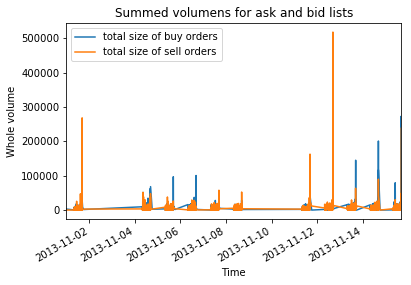

In [10]:
df['sum_buy_bid'].plot(label='total size of buy orders')
df['sum_sell_ask'].plot(label='total size of sell orders')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

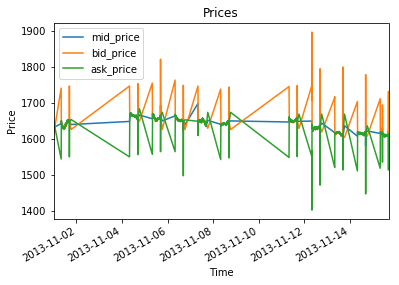

In [11]:
df[['mid_price', 'bid_price', 'ask_price']].plot()
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

Seems that at 2013-09-09 there was some drop in prices

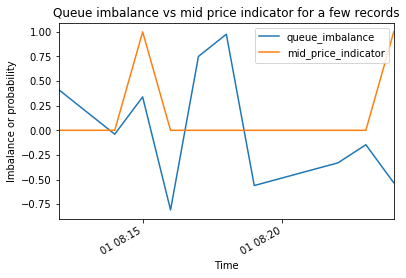

In [13]:
df.iloc[10:20][['queue_imbalance', 'mid_price_indicator']].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Imbalance or probability')
plt.title('Queue imbalance vs mid price indicator for a few records')

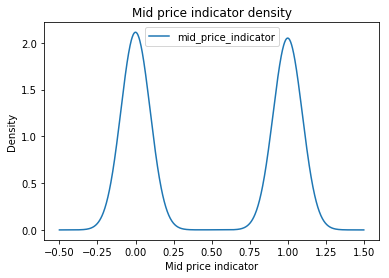

In [14]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

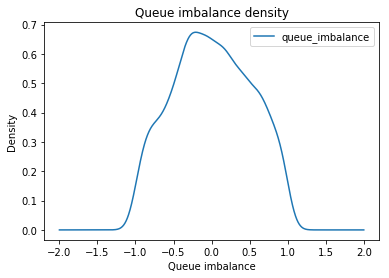

In [15]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Predictions

For predictions we use:

* logistic regression to predict the probability of mid price rising in the next tick
* binary classification (using SVM instead of Logistic Classification) to classify if the mid price will raise

Feature for prediction is queue_imbalance and we want to predict mid_price_indicator.

We perform in-sample tests and very naive out-of-sample tests.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np

def svm_classification(df, start_idx, end_idx):
    clf = svm.SVC()        
    X = df['queue_imbalance'][start_idx:end_idx].values.reshape(-1, 1)
    y = df['mid_price_indicator'][start_idx:end_idx].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

def logistic_regression(df, start_idx, end_idx):
    clf = LogisticRegression()     
    X = df['queue_imbalance'][start_idx:end_idx].values.reshape(-1, 1)
    y = df['mid_price_indicator'][start_idx:end_idx].values.ravel()
    y[0] = 0
    clf.fit(X, y)
    return clf

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Test for logistic regression in-sample

We compare with our results using mean square error:

* predicted probability vs $0.5$ probability
* predicted probability vs mid_price_indicator
* predicted mid_price_indicator vs  $0.5$ probability
* predicted mid_price_indicator vs mid_price_indicator

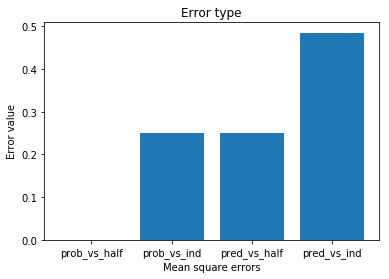

In [17]:
reg = logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
prob_vs_half = ((0.5 * np.ones(len(probabilities)) - probabilities) ** 2).mean()
prob_vs_ind = ((df['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df['queue_imbalance'].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df['mid_price_indicator'] - predictions) ** 2).mean()

plt.bar(np.arange(4), [prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(4), ['prob_vs_half', 'prob_vs_ind', 'pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')

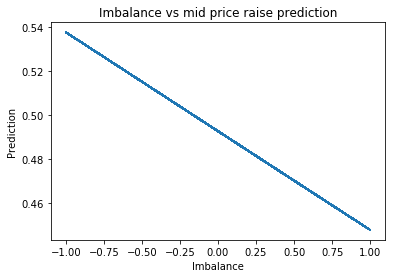

In [18]:
plt.plot(df['queue_imbalance'].values, sigmoid(reg.coef_[0] * df['queue_imbalance'].values + reg.intercept_))
plt.title('Imbalance vs mid price raise prediction')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')

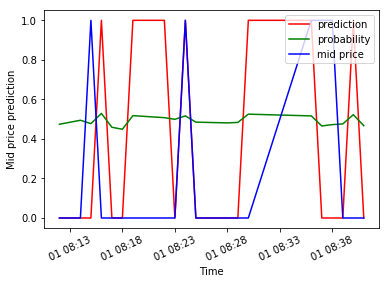

In [19]:
st = 10
end = 30

plt.plot(df.index[st:end], predictions[st:end], 'r', label='prediction')
plt.plot(df.index[st:end], probabilities[st:end], 'g', label='probability')
plt.plot(df.index[st:end], df['mid_price_indicator'].values[st:end], 'b', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

### Test for SVM in-sample

We compare with our results using mean square error:

* predicted mid_price_indicator vs  $0.5$ probability
* predicted mid_price_indicator vs mid_price_indicator

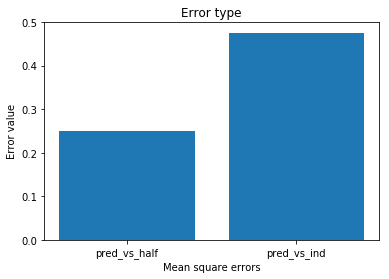

In [20]:
reg = svm_classification(df, 0, len(df))

predictions = reg.predict(df['queue_imbalance'].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df['mid_price_indicator'] - predictions) ** 2).mean()

plt.bar(np.arange(2), [pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(2), ['pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')

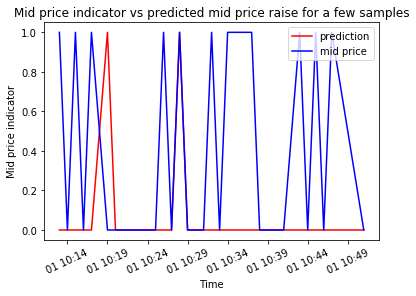

In [21]:
st = 100
end = 130

plt.plot(df.index[st:end], predictions[st:end], 'r', label='prediction')
plt.plot(df.index[st:end], df['mid_price_indicator'].values[st:end], 'b', label='mid price')
plt.xlabel('Time')
plt.ylabel('Mid price indicator')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.title('Mid price indicator vs predicted mid price raise for a few samples')

### Testing out-of-sample

In [22]:
test_idx = 4000
reg = logistic_regression(df, 0, test_idx) # naive approach

probabilities = reg.predict_proba(df['queue_imbalance'].iloc[test_idx:len(df)].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
prob_vs_half = ((0.5 * np.ones(len(probabilities)) - probabilities) ** 2).mean()
prob_vs_ind = ((df['mid_price_indicator'].iloc[test_idx:len(df)] - probabilities) ** 2).mean()

predictions = reg.predict(df['queue_imbalance'].iloc[test_idx:len(df)].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df['mid_price_indicator'].iloc[test_idx:len(df)] - predictions) ** 2).mean()

plt.bar(np.arange(4), [prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(4), ['prob_vs_half', 'prob_vs_ind', 'pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
plt.plot(df['queue_imbalance'][test_idx:len(df)].values, 
         sigmoid(reg.coef_[0] * df['queue_imbalance'][test_idx:len(df)].values + reg.intercept_))

plt.xlabel('Imbalance')
plt.ylabel('Mid price prediction')
plt.title('Imbalance vs mid price prediction')

It looks like we never predict that the mid price will raise.

In [ ]:
end = 30
end_idx = test_idx + end

plt.plot(df.index[test_idx:end_idx], df['mid_price_indicator'].values[test_idx:end_idx], 'b', label='mid price')
plt.plot(df.index[test_idx:end_idx], predictions[0:end], 'r', label='prediction')
plt.plot(df.index[test_idx:end_idx], probabilities[0:end], 'g', label='probability')
plt.xticks(rotation=25)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend(loc=1)
plt.title('Predictions of mid price')

In [23]:
reg = svm_classification(df, 0, test_idx)

predictions = reg.predict(df['queue_imbalance'].iloc[test_idx:len(df)].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df['mid_price_indicator'].iloc[test_idx:len(df)] - predictions) ** 2).mean()

plt.bar(np.arange(2), [pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(2), ['pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
end = 30
end_idx = test_idx + end

plt.plot(df.index[test_idx:end_idx], predictions[0:end], 'r', label='prediction of mid price indicator')
plt.plot(df.index[test_idx:end_idx], df['mid_price_indicator'].iloc[test_idx:end_idx].values, 
         'b', label='mid price indicator')
plt.xlabel('Time')
plt.ylabel('Mid price indicator')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.title('Mid price indicator vs predicted mid price raise')

## Conclusions

Predicted probability that `mid_price` will raise is close to `0.5` and it's only slightly better than "no prediction" (so probability $0.5$). Computed **mean square error** value for predictions is about $0.25$, so the same as the result in [1](#1). It seems it doesn't matter if we use SVM or LogisticRegression library for predictions in this case for this data.


Of course data for testing was insufficient, to help a bit with that there could be better sample construction method used.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 